In [62]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal 

print("Setup Complete")

Setup Complete


In [84]:
ppg_filepath = "../golden_data/ppg_golden_data.csv"

ppg_data = pd.read_csv(ppg_filepath, nrows=50000)

In [85]:
# Định nghĩa các tham số
fs = 100.0  # Tần số lấy mẫu, ví dụ 50 Hz
lowcut = 0.5  # Tần số cắt thấp, 0.5 Hz
highcut = 5.0  # Tần số cắt cao, 5 Hz
order = 4  # Bậc của bộ lọc

# Hàm tính toán hệ số bộ lọc Butterworth trong miền tần số liên tục (s-domain)
def butter_bandpass_s(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    # Các tần số cắt chuẩn hóa
    omega_low = 2 * np.pi * low
    omega_high = 2 * np.pi * high
    
    # Các cực của bộ lọc Butterworth
    poles = []
    for k in range(order):
        theta = np.pi * (2*k + 1) / (2*order)
        pole = complex(-np.sin(theta), np.cos(theta))
        poles.append(pole)
    
    # Các hệ số trong miền s
    b = np.poly([0] * order)
    a = np.poly(poles)
    
    return b, a

# Hàm chuyển đổi từ miền s sang miền z bằng phương pháp bilinear
def bilinear_transform(b, a, fs):
    T = 1.0 / fs
    degree = len(a) - 1
    a_z = np.zeros(degree + 1)
    b_z = np.zeros(degree + 1)
    
    for k in range(degree + 1):
        b_z[k] = b[k].real * T**k
        a_z[k] = a[k].real * T**k
    
    # Chuẩn hóa các hệ số
    b_z /= a_z[0]
    a_z /= a_z[0]
    
    return b_z, a_z

# Hàm lọc tín hiệu sử dụng các hệ số z-domain
def apply_filter(data, b, a):
    data = np.asarray(data, dtype=np.float64)  # Đảm bảo dữ liệu đầu vào là kiểu float64
    y = np.zeros_like(data, dtype=np.float64)  # Tạo mảng kết quả kiểu float64
    for i in range(len(data)):
        y[i] = b[0] * data[i]
        for j in range(1, len(b)):
            if i-j >= 0:
                y[i] += b[j] * data[i-j]
        for j in range(1, len(a)):
            if i-j >= 0:
                y[i] -= a[j] * y[i-j]
    return y


In [86]:

b_s, a_s = butter_bandpass_s(lowcut, highcut, fs, order)
    
# Chuyển đổi các hệ số từ miền s sang miền z
b_z, a_z = bilinear_transform(b_s, a_s, fs)
    
# Áp dụng bộ lọc
filtered_sig = apply_filter(ppg_data, b_z, a_z)

In [87]:
print(filtered_sig)

[[ 981.        ]
 [ 958.36523463]
 [ 963.6217752 ]
 ...
 [2276.566131  ]
 [2308.73807778]
 [2368.88660917]]


<Axes: >

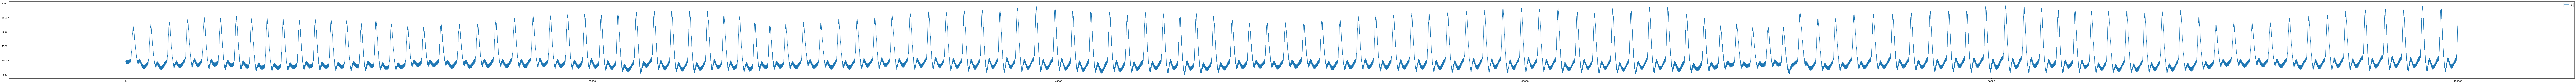

In [88]:
# Hiển thị tín hiệu trước và sau khi lọc
plt.figure(figsize=(200,6))
sns.lineplot(data=filtered_sig)